## Correlation of price vs return

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from __future__ import division

Let's create three fake asset prices that are correlated.

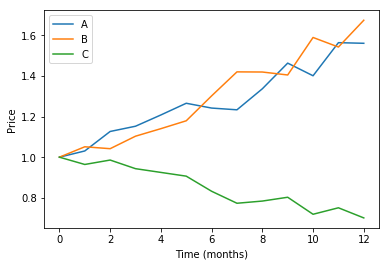

In [2]:
# Log returns generated from the standard normal distribution.
# I've hardcoded these so results are reproducible.
log_returns = np.array([
    -0.17110692, +0.84823544, -0.30048295, +0.12073905,
    +0.11402267, -1.01943574, -0.81256609, +0.70153254,
    +0.87145775, -1.44572583, +1.21312518, -0.72748137
])

# Create price from returns, starting from $1, and given
# an average rate of return (drift)
def price(mu, log_r):
    # We will generate prices for 12 months, assuming
    # a volatility of 20%.
    sigma = 0.2
    dt = 1/len(log_r)
    
    # Generate price using geometric brownina motion
    s = np.exp(np.cumsum((mu - sigma**2/2.)*dt + sigma*np.sqrt(dt)*log_r))
    return np.insert(s, 0, 1)

# Generate stock prices
prices = pd.DataFrame({
    "A": price(0.5, log_returns),
    "B": price(0.5, -1 * log_returns),
    "C": price(-0.3, log_returns)
})

prices.plot()
plt.ylabel('Price')
plt.xlabel('Time (months)');

### Puzzle

At first glance, it seems like stocks A and B are positively correlated, since they are moving together, and stocks A and C are negatively correlated, since they are moving in opposite directions. Let's look at the correlation of prices:

In [3]:
prices.corr()

,A,B,C
A,1.000000,0.910096,-0.879717
B,0.910096,1.000000,-0.992554
C,-0.879717,-0.992554,1.000000


This confirms our intuition. Now, let's look at the correlation of log returns ($log(S_1/S_0)$ is often quite close to the percentage return $(S_1 - S_0)/S_0$, which is more commonly used):

In [4]:
returns = np.log(prices).diff()[1:]
returns.corr()

,A,B,C
A,1.0,-1.0,1.0
B,-1.0,1.0,-1.0
C,1.0,-1.0,1.0


What in the world? It's telling us that A and B are perfectly anti-correlated ($\rho = -1$), and A and C are perfectly correlated ($\rho = +1$). This is the exact opposite of what we saw from the prices. What is going on?

Another thing that's counter-inuitive is that we normally think about positive correlation as assets moving together in the same direction. Looking at A and C from $t=0$ to $t=1$, we see that A increases by about $+3.0\%$, while B decreases by about $-3.7\%$. How can this happen when A and C's returns are perfectly correlated?

### Resolution

Let's remember how the correlation between two random variables $X$ and $Y$ is defined:

\begin{equation}
\rho_{XY} = \frac{\langle(X-\mu_X)(Y-\mu_Y)\rangle}{\sigma_X\sigma_Y}
\end{equation}

where
\begin{equation}
\mu_X = \langle X\rangle, \qquad
\sigma_X = \langle (X - \mu_X)^2\rangle,
\end{equation}
and similary for $Y$. Another way to write this is in terms of the standardized data:

\begin{equation}
\rho_{XY} = \langle Z_XZ_Y\rangle
\end{equation}
where
\begin{equation}
Z_X = \frac{X - \mu_X}{\sigma_X}, \qquad
Z_Y = \frac{Y - \mu_Y}{\sigma_Y}.
\end{equation}

Let's look at the standardized returns:

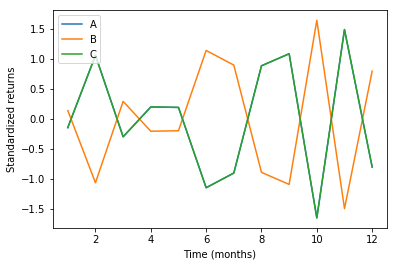

In [5]:
std_returns = (returns - returns.mean())/returns.std()
std_returns.plot()
plt.ylabel('Standardized returns')
plt.xlabel('Time (months)')
plt.legend(loc=2);

Ah! So now we see that A and C's standardized returns follow each other exactly, and B has the exact opposite pattern.

The key to the second puzzle is that what enters into the correlation computation is the difference between returns and their mean. Let's look at the mean return of each stock:

In [6]:
returns.mean()

A    0.037076
B    0.042924
C   -0.029590
dtype: float64

We see that the return of A from $t=0$ to $t=1$ is actually below its average by about $-0.7\%$, even though it's positive. The return on C is also below its average by the same amount. That's why they move in opposite directions, but are still perfectly correlated.

### Correlation of prices doesn't make sense

So what's with the correlation of prices? Let's remember what we're really doing when we calculate the sample correlation coefficient (e.g. using `prices.corr`). The assumption is that there are two random variables $X$ and $Y$ with an underlying joint probability density function $p(x, y)$. We collect *independent* samples $(x_1, y_1), (x_2, y_2), \dots, (x_N, y_N)$ from this distribution and then compute the sample correlation coefficient $\hat{\rho}$ as follows:

\begin{equation}
\hat{\rho} = \frac{\sum_{i=1}^{N}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{N}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{N}(y_i - \bar{y})^2}},
\end{equation}
where as usual
\begin{equation}
\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i, \qquad
\bar{y} = \frac{1}{N}\sum_{i=1}^N y_i.
\end{equation}
Under the assumption of independence of samples, it can be shown that $\langle \hat{\rho}\rangle \to \rho$ for a sufficiently large sample size $N$.

Now let X and Y denote the price of assets A and B, respectively. The sample $(x_i, y_i)$ is the price of A and B at time $t=i$. Is it true that $(x_1, y_1), (x_2, y_2), \dots, (x_N, y_N)$ are independent samples of some underlying distribution? For the Browninan motion model we've used for stock prices, the answer is a resounding no. If we were to generate many paths and look at the distribution of prices at each point in time, we'll find that they are different. By construction $log(x_t) \sim \mathcal{N}((\mu - \sigma^2/2)t, \sigma^2t)$. If this weren't bad enough, each price depends on the previous time step, so samples are not independent. It would then seem that it doesn't make sense to compute correlation on prices.